In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

from quickstats.plots import UpperLimit1DPlot
from quickstats.plots import UpperLimit2DPlot
from quickstats.plots import Likelihood2DPlot, UpperLimit3DPlot
from quickstats.utils.common_utils import combine_dict
from quickstats.maths.interpolation import get_intersections

%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if "hh_combination_fw_path" not in os.environ:
    os.environ['hh_combination_fw_path'] = os.path.abspath("../../")
outdir_mu = os.environ['hh_combination_fw_path']+'/tutorials/HHH2022/outputs_HHH2022_20220701_noSgHparam_mu/'
outdir_xsection = os.environ['hh_combination_fw_path']+'/tutorials/HHH2022/outputs_HHH2022_20220701_noSgHparam_xsec/'
outdir_likelihood = os.environ['hh_combination_fw_path']+'/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation/'


In [32]:
resonant_type = 'nonres'
combine_tag = 'A-bbbb_bbtautau_bbyy-fullcorr'
def remove_list(data):
    for k, v in data.items():
        for p,v_ in v.items():
            data[k][p] = v_[0]
    return data
channel_label_map = {
    'bbbb': r"$\mathit{b\bar{b}b\bar{b}}$",
    'bbtautau': r"$\mathit{b\bar{b}\tau^+\tau^-}$",
    'bbyy': r"$\mathit{b\bar{b}\gamma\gamma}$",
    'combined': r"Combined",
}
channel_text = {
    'combined': r'$\mathit{HH\rightarrow b\bar{b}\tau^+\tau^- + b\bar{b}\gamma\gamma + b\bar{b}b\bar{b}}$',
    'bbbb': r'$\mathit{HH\rightarrow b\bar{b}b\bar{b}}$',
    'bbyy': r'$\mathit{HH\rightarrow b\bar{b}\gamma\gamma}$',
    'bbtautau': r'$\mathit{HH\rightarrow b\bar{b}\tau^+\tau^-}$',
}
statuses = ['final']

## 1. SM Limit Plot

In [33]:
def get_limit_data(json_name=None, mu_or_xsec='mu'):
    scale_factor = 1
    sm_limit_df = {}
    outdir = outdir_mu if mu_or_xsec == 'mu' else outdir_xsection
    channels = ['bbtautau', 'bbyy', 'bbbb']
    data = {}
    for channel in channels + ['combined']:
        if json_name is None:
            limit_path = os.path.join(outdir, 'limits', resonant_type, channel, combine_tag if channel == 'combined' else '', 'limits.json')
        else:
            limit_path = os.path.join(outdir, 'limits', resonant_type, channel, json_name)

        data[channel] = json.load(open(limit_path))
        
    data_dict = remove_list(data)
    sm_limit_df = pd.DataFrame(data_dict) * scale_factor
    return sm_limit_df

def append_limit_SM(sm_limit_df):
    third_limit = {}
    channels = ['bbtautau', 'bbyy', 'bbbb']
    for channel in channels + ['combined']:
        limit_path = os.path.join(outdir_mu, 'limits', resonant_type, channel, 'limits_asimovData_1_NP_Profile.jsonxsec_br')
        third_limit[channel] = json.load(open(limit_path))['obs']
    sm_limit_df.loc['third'] = third_limit
    return sm_limit_df

def SM_error(ggf_cv, ggf_up, ggf_dn, vbf_cv, vbf_up, vbf_dn):
    up = 1 + np.sqrt(ggf_cv*ggf_cv*ggf_up*ggf_up + vbf_cv*vbf_cv*vbf_up*vbf_up) / (ggf_cv + vbf_cv)
    dn = 1 - np.sqrt(ggf_cv*ggf_cv*ggf_dn*ggf_dn + vbf_cv*vbf_cv*vbf_dn*vbf_dn) / (ggf_cv + vbf_cv)
    return up, dn
    
def plot_SM(sm_limit_df, third = False, status='int', mu_or_xsec='mu'):
    plotting_order = ['combined', 'bbbb', 'bbtautau', 'bbyy' ]
    sm_limit_df = sm_limit_df[plotting_order]
    analysis_label_options = {'fontsize':30, 'energy': '13 TeV', 
                              'loc': (0.03, 0.97),
                              'status': status,
                              'lumi': '126—139 fb$^{-1}$',
                              # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
#                                       'extra_text': r'$m_H=125.09$ GeV//$\sigma_{ggF+VBF}^{SM}=32.7$ fb', # 125.09GeV: 31.02+1.723=32.743;  125GeV: 31.05+1.726=32.776
                              'extra_text': r'$\sigma_{ggF+VBF}^{SM} (\mathit{HH})=32.7$ fb', # 125.09GeV: 31.02+1.723=32.743;  125GeV: 31.05+1.726=32.776
                              }
    if mu_or_xsec=='realxsec':
        total_cross = (31.02+1.723)
        sm_limit_df *= total_cross
        xerrhi, xerrlo = SM_error(ggf_cv=31.02, ggf_up=np.sqrt(np.square(0.03)+np.square(0.06)), ggf_dn=np.sqrt(np.square(0.03)+np.square(0.23)), vbf_cv=1.723, vbf_up=np.sqrt(np.square(0.0003)+np.square(0.021)), vbf_dn=np.sqrt(np.square(0.0004)+np.square(0.021)))
        print(xerrhi, xerrlo)
        xerrhi, xerrlo = xerrhi * total_cross, xerrlo * total_cross
        print(mu_or_xsec, total_cross, xerrlo, xerrhi, '-', xerrlo-total_cross, '+', xerrhi-total_cross)
        analysis_label_options['extra_text'] = r'$\sigma_{ggF+VBF}^{SM} (\mathit{HH})=32.7_{-7.2}^{+2.1}$ fb'
    styles = {
        'figure':{
        },
        'axis':{
            'tick_bothsides': False,
            'major_length': 12,
            },
        'legend':{
            'loc': 'upper right',
            },
    }
    if mu_or_xsec == 'realxsec':
        styles['xtick'] = {
            'format': 'numeric',
            'steps':[1, 2, 3, 4, 5],
        }
    config = {
        'top_margin': 4 if third else 3.7,
    }
    if mu_or_xsec == 'xsec' or mu_or_xsec == 'realxsec':
        cls = ' (95% CL)'
    else:
        cls=''
    labels = {
        'expected': f'Expected limit{cls}\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)',
        'observed': f'Observed limit{cls}'
    }
    if third:
        labels['third'] = 'Expected limit\n(SM hypothesis)'

        
    plotter = UpperLimit1DPlot(sm_limit_df, channel_label_map, line_below=["bbbb"], labels=labels,
                               analysis_label_options=analysis_label_options, styles=styles, config=config)
    xlabel = r"95% CL upper limit on $\mathit{HH}$ signal strength $\mathit{\mu_{HH}}$"
    if mu_or_xsec=='xsec':
        xerrhi, xerrlo = SM_error(ggf_cv=31.02, ggf_up=np.sqrt(np.square(0.03)+np.square(0.06)), ggf_dn=np.sqrt(np.square(0.03)+np.square(0.23)), vbf_cv=1.723, vbf_up=np.sqrt(np.square(0.0003)+np.square(0.021)), vbf_dn=np.sqrt(np.square(0.0004)+np.square(0.021)))
        plotter.add_curve(x=1, xerrlo=xerrlo, xerrhi=xerrhi, label="Theory prediction")
        xlabel = r"$\sigma_{ggF+VBF}(\mathit{HH})\: /\: \sigma_{ggF+VBF}^{SM}$"
    elif mu_or_xsec=='realxsec':
        plotter.add_curve(x=total_cross, xerrlo=xerrlo, xerrhi=xerrhi, label="Theory prediction")
        xlabel = r"$\sigma_{ggF+VBF}(\mathit{HH})$ [fb]"
    ax = plotter.draw(logx=True if mu_or_xsec=='realxsec' else False, xlabel=xlabel, draw_observed=True, draw_stat=False, sig_fig=0 if mu_or_xsec=='realxsec' else 1,
                     draw_third_column = 'Exp.\n(SM)' if third else None, add_text=False if mu_or_xsec=='realxsec' else True
                     )
    if mu_or_xsec == 'realxsec':
        from quickstats.plots.template import create_transform
        from matplotlib.ticker import LogLocator
        transform = create_transform(transform_x='axis', transform_y='data')
        new_styles = {
            'text': {
                'fontsize': 22
            }
        }
        n_category = len(plotter.category_df.columns)
        obs_column, exp_column = 0.775, 0.925
        ax.text(obs_column, n_category + 0.3, 'Obs.',
                horizontalalignment='center',
                verticalalignment='center',
                transform=transform,
                **new_styles['text'])
        ax.text(exp_column, n_category + 0.3, 'Exp.',
                horizontalalignment='center',
                verticalalignment='center',
                transform=transform,
                **new_styles['text'])
        for i, chan in enumerate(plotting_order):
            ax.text(exp_column, i + 0.5, int(float(f"{{:.{2}g}}".format(sm_limit_df.loc['0'][chan]))),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=transform,
                    **new_styles['text'])
            ax.text(obs_column, i + 0.5, int(float(f"{{:.{2}g}}".format(sm_limit_df.loc['obs'][chan]))),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=transform,
                    **new_styles['text'])
        ax.set_xlim([20, 80 * total_cross ])
        ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1,2,5)))
        ax.set_xticklabels([1,2,5,10,20,50, 100, 200, 500, 1000, 2000])
    else:
        ax.set_xlim([0, 30 if mu_or_xsec == 'mu' else 20])
    outdir = outdir_mu if mu_or_xsec == 'mu' else outdir_xsection
    os.makedirs(os.path.join(outdir, f'figures/SM/{status}/'), exist_ok=True)
    filename = os.path.join(outdir, f'figures/SM/{status}/', f"SM_limit{'withSM' if third else ''}_{mu_or_xsec}_{status}.pdf")
#     plt.savefig(filename, bbox_inches="tight")
    sm_limit_df.to_csv(filename.replace('.pdf', '.csv'))
    print('Save to', filename)


### 1.2 Plotting

In [34]:
sm_limit_df_mu = get_limit_data(mu_or_xsec='mu')
sm_limit_df_xsec = get_limit_data(mu_or_xsec='xsec')
# sm_limit_df2 = get_limit_data('limits_asimovData_1_NP_Profile.json')
# sm_limit_df_mu = append_limit_SM(sm_limit_df_mu)

Save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_noSgHparam_mu/figures/SM/final/SM_limit_mu_final.pdf
1.0635616614320507 0.780254516970486
realxsec 32.743 25.547873649164625 34.824199480269634 - -7.195126350835377 + 2.081199480269632
Save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_noSgHparam_xsec/figures/SM/final/SM_limit_realxsec_final.pdf


/afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/submodules/quickstats/quickstats/plots/upper_limit_1D_plot.py:197: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(xlim[0] - (xlim[1]/0.7 - xlim[1])*0.5, xlim[1]/0.7)
/tmp/zhangr/ipykernel_27007/307659085.py:130: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([1,2,5,10,20,50, 100, 200, 500, 1000, 2000])


<Figure size 432x288 with 0 Axes>

<Figure size 799.992x743.976 with 0 Axes>

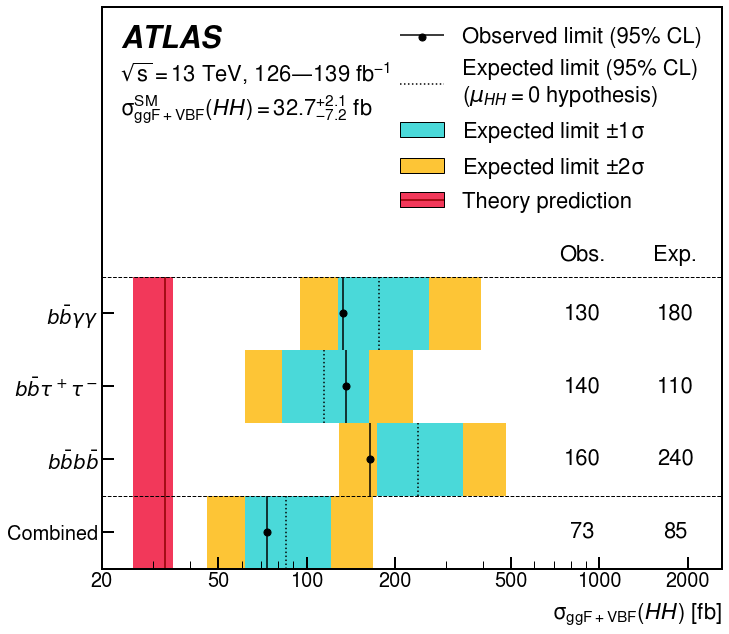

In [35]:
for status in statuses:
    plot_SM(sm_limit_df_mu, third=False, status=status, mu_or_xsec='mu')
#     plot_SM(sm_limit_df_xsec, third=False, status=status, mu_or_xsec='xsec')
    plot_SM(sm_limit_df_xsec, third=False, status=status, mu_or_xsec='realxsec')
#     plot_SM(sm_limit_df_mu, third=True, status=status)
# #     plot_SM(sm_limit_df2, third=False, status=status)


## Cross section limit

In [36]:
# exp, obs (SM * limit (fb))
32.743 * 2.60595284341142, 32.743 * 2.23216499667234, 32.743 * 2.6059963916427002, 32.743 * 2.232178586553075


(85.32671395182014, 73.08777848604242, 85.32813985155694, 73.08822345950735)

## 2. Cross section Scan - kl

In [55]:
def get_xsection_scan_limit(poi = 'klambda', EWcorr=False):
    kl_param_limit_df = {}
    POI = {
        'klambda': 'klambda',
        'k2v': 'k2V',
    }
    channels = ['bbbb', 'bbtautau', 'bbyy']
    data = {}
    outdir = outdir_likelihood if EWcorr else outdir_xsection
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir, 'xsection_scan', channel, poi, 'limits.json')
        data[channel] = json.load(open(limit_path))
        
    for channel in data:
        df = pd.DataFrame(data[channel]).set_index([POI[poi]])
        kl_param_limit_df[channel] = df

    return kl_param_limit_df
 

def get_intersections2(lambdas, n_exp, lambdas_th, n_th):
    # get the intersection between expected and theory prediction
    
    # interpolate expected limit with same number of datapoints as used in theory prediction
    interpolated_limit = np.interp(lambdas_th, lambdas, n_exp) 

    #limitm1 = n*np.array(limit_bands[0]) - 1
    limitm1 = interpolated_limit - n_th 
    idx = np.argwhere(np.diff(np.sign(limitm1))).flatten() # determines what index intersection points are at 

    #linear interpolation to get exact intercepts: x = x1 + (x2-x1)/(y2-y1) * (y-y1)
    #y = 0 -> x = x1 - (x2-x1)/(y2-y1) * y1
    intersections = [lambdas_th[x] - (lambdas_th[x+1] - lambdas_th[x])/(limitm1[x+1] - limitm1[x]) * limitm1[x] for x in idx]
    return intersections



In [56]:
def theory_cross_section_kl(kl, mH, production, s=13):
    sm_xsec_vbf = {
        '125.09': 1.723,
        '125': 1.726,
    }
    sm_xsec_ggF = {
        '125.09': 31.02,
        '125': 31.05,
    }
    SCALE_GGF = sm_xsec_ggF[str(mH)]/31.0358  #correct to xs at mH
    SCALE_VBF = sm_xsec_vbf[str(mH)]/(4.581-4.245+1.359)

    kl = np.array(kl)
    
    # Calculate ggF theory curve
    if production.lower() != 'vbf':
        #https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH#Latest_recommendations_for_gluon
        xs_ggF = (70.3874-50.4111*kl+11.0595*np.square(kl))*SCALE_GGF #XS in fb
        xs_ggF_up = xs_ggF * np.sqrt(np.square((np.maximum(76.6075 - 56.4818*kl + 12.635*np.square(kl), 75.4617 - 56.3164*kl + 12.7135*np.square(kl)) * SCALE_GGF / xs_ggF - 1)) + 0.03**2)
        xs_ggF_down = xs_ggF * np.sqrt(np.square((np.minimum(57.6809 - 42.9905*kl + 9.58474*np.square(kl), 58.3769 - 43.9657*kl + 9.87094*np.square(kl)) * SCALE_GGF / xs_ggF - 1)) + 0.03**2)
    
    # Calculate VBF theory curve
    if production.lower() != 'ggf':
        #https://indico.cern.ch/event/995807/contributions/4184798/attachments/2175756/3683303/VBFXSec.pdf
        xs_VBF = (4.581-4.245*kl+1.359*np.square(kl))*SCALE_VBF
        xs_VBF_up = xs_VBF * np.sqrt(0.0003**2 + 0.021**2)
        xs_VBF_down = xs_VBF * np.sqrt(0.0004**2 + 0.021**2)
    
    # Calculate ggF+VBF theory curve
    if production.lower() == 'all':
        xs_HH = xs_ggF + xs_VBF
        xs_HH_up = np.sqrt(np.square(xs_ggF_up) + np.square(xs_VBF_up))
        xs_HH_down = np.sqrt(np.square(xs_ggF_down) + np.square(xs_VBF_down))

    if s == 14:
        xs_HH = xs_ggF * 1.18 + xs_VBF * 1.19
        xs_HH_up /= 2
        xs_HH_down /= 2
        assert(production.lower() == 'all'), 'for ggF or VBF only projection, please revisit factors on the theory error.'
        
    if production.lower() == 'ggf':
        return xs_ggF, xs_ggF+xs_ggF_up, xs_ggF-xs_ggF_down
    elif production.lower() == 'vbf':
        return xs_VBF, xs_VBF+xs_VBF_up, xs_VBF-xs_VBF_down
    elif production.lower() == 'all':
        return xs_HH, xs_HH+xs_HH_up, xs_HH-xs_HH_down
    else:
        assert(0), f'production {production} is not implemented'



In [83]:
# from quickstats.maths.interpolation import get_intersections

def plot_individual(channel, ax, plotter, kl_param_limit_df, poi, linewidth=3):
    from copy import deepcopy
    color_pallete = {
        'bbbb': 'b',
        'bbtautau': "#008F00",
        'bbyy': "#9A0EEA",
        'combined': 'k',
    }
    result = {}
    handles_map = {}
    for subchannel in kl_param_limit_df:
        data = kl_param_limit_df[subchannel]
        indices = data.index.astype(float).values
        exp_limits = data['0'].values * plotter.scale_factor
        obs_limits = data['obs'].values * plotter.scale_factor
        result[f'{poi}'] = indices
        result[f'exp_{subchannel}'] = exp_limits
        result[f'obs_{subchannel}'] = obs_limits
        if subchannel == channel:
            alpha = 0
        else:
            alpha = 1
        ax.semilogy(indices, exp_limits, color=color_pallete[subchannel], linestyle='--', alpha=alpha, label=channel_label_map[subchannel], linewidth=linewidth)
        handle_channels = ax.semilogy(indices, obs_limits, color=color_pallete[subchannel], linestyle='-', linewidth=linewidth, alpha=1, label=channel_label_map[subchannel])
        handles_map[subchannel] = handle_channels[0]
    return pd.DataFrame.from_dict(result)

    def update_legend_handles(handles):
        import matplotlib
        legend_data = {}

        for key in handles:
            handle = handles[key]
            if isinstance(handle, matplotlib.container.Container):
                label = handle.get_label()
            elif isinstance(handle, (tuple, list)):
                label = handle[0].get_label()
            else:
                label = handle.get_label()
            if label and not label.startswith('_'):
                legend_data[key] = {
                    'handle': handle,
                    'label': label
                }
            else:
                raise RuntimeError(f"the handle {handle} does not have an associated label")
        return legend_data

    def get_legend_handles_labels(legend_data):
        handles = []
        labels = []

        for key in ['bbyy', 'bbtautau', 'bbbb', 'combined']:
            if key in legend_data:
                handle = legend_data[key]['handle']
                label = legend_data[key]['label']
                handles.append(handle)
                labels.append(label)
        return handles, labels

    legend_data = update_legend_handles(handles_map)
    handles_sec, labels_sec = get_legend_handles_labels(legend_data)

    ax.add_artist(ax.get_legend())
    sec_style = deepcopy(plotter.styles['legend'])
    sec_style['loc'] = (0.7, 0.02)
    ax.legend(handles_sec, labels_sec, **sec_style)


def plot_xsection_scan_kl(kl_param_limit_df, channel, mH, production, poi='klambda', xmin=None, xmax=None, ymin=None, ymax=None, add_individual=True, disable_error=False, status='int'):
    results = {}
    analysis_label_options = {
        'status': status,
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    styles = {
        'legend':{
            'loc': (0.58, 0.58) if not disable_error else (0.58, 0.73),
            'fontsize': 17
        },
        'axis':{
            'tick_bothsides': True,
            'major_length': 12,
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    }
    
    poi_name = {
        'klambda': r'$\mathit{\kappa_\lambda}$',
        'k2v': r'$\mathit{\kappa_{2V}}$',
        'kv': r'$\mathit{\kappa_{V}}$',
    }
    ylabel = {
        'ggf': r"$\sigma_{ggF}(\mathit{HH})$ [fb]",
        'vbf': r"$\sigma_{VBF}(\mathit{HH})$ [fb]",
        'all': r"$\sigma_{ggF+VBF}(\mathit{HH})$ [fb]",
    }
    config = {
        'observed_plot_styles': {
            'marker': 'None'
        }
    }
    
    klambda_values, klambda_values2 = kl_param_limit_df['combined'].index.astype(float).values, kl_param_limit_df['bbyy'].index.astype(float).values
    assert(klambda_values.shape == klambda_values2.shape), f'{klambda_values.shape} {klambda_values2.shape}'
    theory_xs_values, theory_xs_upper, theory_xs_lower = theory_cross_section_kl(klambda_values, mH, production)

    klambda_values_dense = np.linspace(min(klambda_values), max(klambda_values), 200000) 
    theory_xs_values_dense, theory_xs_upper_dense, theory_xs_lower_dense = theory_cross_section_kl(klambda_values_dense, mH, production)

    plotter = UpperLimit2DPlot(kl_param_limit_df[channel], labels={'expected': 'Expected limit (95% CL)\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)'},
                               scale_factor=theory_xs_values, styles=styles,
                               analysis_label_options=analysis_label_options, config = config)
    plotter.add_curve(klambda_values_dense, theory_xs_values_dense, theory_xs_lower_dense, theory_xs_upper_dense, 
                      label="Theory prediction")
    plotter.add_highlight(1, theory_cross_section_kl(1, mH, production)[0],
                          label="SM prediction")
    xmin = kl_param_limit_df[channel].index.min() if not xmin else xmin
    xmax = kl_param_limit_df[channel].index.max() if not xmax else xmax
    ylim = {
        'klambda': [(10 if not ymin else ymin), (7e4 if not ymax else ymax)],
        'k2v': [1, 1e4],
    }
    ax = plotter.draw(xlabel=poi_name[poi], ylabel=ylabel[production.lower()],
                 draw_observed=True, log=True, ylim=ylim[poi], xlim=[xmin, xmax], draw_errorband=not disable_error)

    intersections_exp = get_intersections2(klambda_values, 
                                      theory_xs_values*kl_param_limit_df[channel]['0'],
                                      klambda_values_dense, theory_xs_values_dense)

    intersections_obs = get_intersections2(klambda_values, 
                                      theory_xs_values*kl_param_limit_df[channel]['obs'],
                                      klambda_values_dense, theory_xs_values_dense)
    ax.annotate(r'Expected: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections_exp[0], intersections_exp[1]), 
                (0.05, 0.08), xycoords = 'axes fraction', fontsize = 18)
    ax.annotate(r'Observed: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections_obs[0], intersections_obs[1]), 
                (0.05, 0.15), xycoords = 'axes fraction', fontsize = 18)
    results[channel] = {}
    results[channel]['exp_low'] = intersections_exp[0]
    results[channel]['exp_high'] = intersections_exp[1]
    results[channel]['obs_low'] = intersections_obs[0]
    results[channel]['obs_high'] = intersections_obs[1]
    df = pd.DataFrame.from_dict(results, orient='index')

    save_foler = outdir_xsection+f"/figures/xsection_scan/{status}/"
    os.makedirs(save_foler, exist_ok=True)
    suffix = ''

    if add_individual:
        suffix += '_withindiv'
    if disable_error:
        suffix += '_noError'

    filename = save_foler+f"{poi}_limit_parameterised_ws_{channel}{suffix}_{status}.pdf"
    
    # Add individual curves on top
    if channel == 'combined' and add_individual:
        result_df = plot_individual(channel, ax, plotter, kl_param_limit_df, poi)
        result_df.to_csv(filename.replace('.pdf', '_individual.csv'), index=False)

    plt.savefig(filename, bbox_inches="tight")
    df_xsec = kl_param_limit_df[channel].mul(theory_xs_values, axis=0)
    df_xsec.to_csv(filename.replace('.pdf', '.csv'))
    df.to_csv(filename.replace('.pdf', '_interval.csv'))
    print("save to", save_foler)
    return df
    

In [84]:
poi = 'klambda'

kl_param_limit_df_ewcorr = get_xsection_scan_limit(poi = poi, EWcorr=True)
# kl_param_limit_df_noewcorr = get_xsection_scan_limit(poi = poi, EWcorr=False)
kl_param_limit_df_ewcorr.keys()

dict_keys(['bbbb', 'bbtautau', 'bbyy', 'combined'])

save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_noSgHparam_xsec//figures/xsection_scan/final/


,exp_low,exp_high,obs_low,obs_high
combined,-0.974016,7.082874,-0.582547,6.648438


<Figure size 432x288 with 0 Axes>

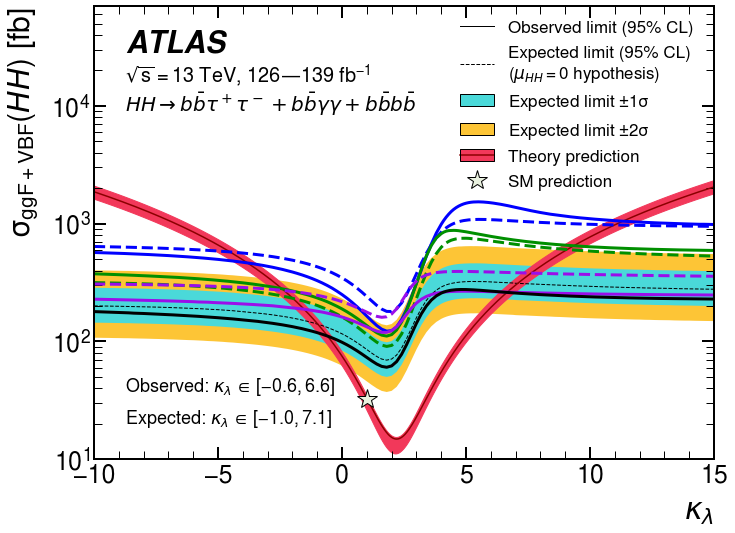

In [85]:
mH = "125.09"
production = 'all'

# plot_xsection_scan_kl(kl_param_limit_df_ewcorr, 'bbbb', mH, production, poi)
# plot_xsection_scan_kl(kl_param_limit_df_ewcorr, 'bbtautau', mH, production, poi)
# plot_xsection_scan_kl(kl_param_limit_df_ewcorr, 'bbyy', mH, production, poi)

for status in statuses:
    df = plot_xsection_scan_kl(kl_param_limit_df_ewcorr, 'combined', mH, production, poi, xmin=-10, xmax=15, status=status)
#     plot_xsection_scan_kl(kl_param_limit_df_ewcorr, 'combined', mH, production, poi, xmin=-4, xmax=10, ymax=5e4, add_individual=False, status=status)
    # plot_xsection_scan_kl(kl_param_limit_df_ewcorr, 'combined', mH, production, poi, xmin=-10, xmax=15, disable_error=True, status=status)

    display(df)

## 3. Cross section Scan - k2v

In [67]:
import sympy
def get_theory_combination_function(mH):
    # https://twiki.cern.ch/twiki/bin/view/LHCPhysics/LHCHWGHH?redirectedfrom=LHCPhysics.LHCHXSWGHH
    sm_N3LO_xsec = {
        '125.09': 1.723,
        '125': 1.726,
    }[str(mH)]

    # Below xsec values are from AMI as of 9 December 2020, for tag: e8263_e7400_s3126_r10201
    basis_xsec_list = [
        # ([k2v, kl, kv], xsec)
        ([1, 1, 1], 1.18),
        ([1.5, 1, 1], 2.30),
        ([2, 1, 1], 9.97),
        ([1, 0, 1], 3.17),
        ([1, 10, 1], 67.4),
        ([1, 1, 1.5], 45.4),
    ]
    xsec_correction = sm_N3LO_xsec / basis_xsec_list[0][1]

    theory_basis_list, xsec_list = zip(*basis_xsec_list)
    corrected_xsecs = [xsec * xsec_correction for xsec in xsec_list]

    theory_amplitude_function = get_amplitude_function(
        theory_basis_list, full_amplitude=True
    )
    theory_combination_function = lambda couplings: theory_amplitude_function(
        *couplings, *corrected_xsecs
    )
    return theory_combination_function

def get_amplitude_function(basis_list, full_amplitude=False, diagram_term_list=None):
    basis_states = [[sympy.Rational(param) for param in basis] for basis in basis_list]

    _k2v = sympy.Symbol("\kappa_{2V}")
    _kl = sympy.Symbol("\kappa_{\lambda}")
    _kv = sympy.Symbol("\kappa_{V}")

    if diagram_term_list is None:
        diagram_term_list = [
            lambda k2v, kl, kv: kv ** 2 * kl ** 2,
            lambda k2v, kl, kv: kv ** 4,
            lambda k2v, kl, kv: k2v ** 2,
            lambda k2v, kl, kv: kv ** 3 * kl,
            lambda k2v, kl, kv: k2v * kl * kv,
            lambda k2v, kl, kv: kv ** 2 * k2v,
        ]

    combination_matrix = sympy.Matrix(
        [[term(*base) for term in diagram_term_list] for base in basis_states]
    )
    inversion = combination_matrix.inv()
    term_vector = sympy.Matrix([[term(_k2v, _kl, _kv)] for term in diagram_term_list])
    if full_amplitude:
        amplitudes = sympy.Matrix(
            [sympy.Symbol(f"A{n}") for n in range(len(diagram_term_list))]
        )
        final_amplitude = (term_vector.T * inversion * amplitudes)[0]
        amplitude_function = sympy.lambdify(
            [_k2v, _kl, _kv] + [*amplitudes], final_amplitude, "numpy"
        )
        return amplitude_function

    else:
        final_weight = term_vector.T * inversion
        reweight_vector = sympy.lambdify([_k2v, _kl, _kv], final_weight, "numpy")
        return reweight_vector

In [89]:
def plot_xsection_scan_k2v(k2v_param_limit_df, channel, mH, production='vbf', poi='k2v', xmin=-2, xmax=4, add_individual=True, disable_error=False, status="int"):
    results = {}
    kl_value, kv_value = 1, 1
    mod_vals_dense = k2v_param_limit_df['bbyy'].index.astype(float).values

    theory_cross_section_k2v = get_theory_combination_function(mH)

    k2v_values =  k2v_param_limit_df['bbyy'].index.astype(float).values
    theory_xs_values = theory_cross_section_k2v((np.array(k2v_values), kl_value, kv_value))

    k2v_values_dense = np.linspace(min(k2v_values), max(k2v_values), 200000) 
    theory_xs_values_dense = theory_cross_section_k2v((np.array(k2v_values_dense), kl_value, kv_value))
    
    if production.lower() == 'vbf':
        pass # not include ggf xs
    elif production.lower() == 'all':
        # For k2v variations, take ggF xs as SM ggF xs
        theory_xs_values_ggf, theory_xs_upper_ggf, theory_xs_lower_ggf = theory_cross_section_kl(kl_value, mH, 'ggf')
        theory_xs_values += np.repeat(theory_xs_values_ggf, len(k2v_values))
        theory_xs_values_ggf_dense, theory_xs_upper_ggf_dense, theory_xs_lower_ggf_dense = theory_cross_section_kl(kl_value, mH, 'ggf')
        theory_xs_values_dense += np.repeat(theory_xs_values_ggf_dense, len(k2v_values_dense))
    else:
        assert(0), f'production {production} is not implemented'

        
    analysis_label_options = {
        'status': status,
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    styles = {
        'legend':{
            'loc': (0.58, 0.58),
            'fontsize': 17
        },
        'axis':{
            'tick_bothsides': True,
            'major_length': 12,
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    }
    
    poi_name = {
        'klambda': r'$\mathit{\kappa_\lambda}$',
        'k2v': r'$\mathit{\kappa_{2V}}$',
    }
    ylabel = {
        'vbf': r"$\sigma_{VBF}(\mathit{HH}) [fb]$",
        'all': r"$\sigma_{ggF+VBF}(\mathit{HH}) [fb]$",
    }
    
    plotter = UpperLimit2DPlot(k2v_param_limit_df[channel],  labels={'expected': 'Expected limit (95% CL)\n'+r'($\mathit{\mu_{HH}} = 0$ hypothesis)'},
                               scale_factor=theory_xs_values, styles=styles,
                               analysis_label_options=analysis_label_options)
    plotter.add_curve(k2v_values_dense, theory_xs_values_dense, theory_xs_values_dense, theory_xs_values_dense, 
                      label="Theory prediction")
    SM_xs = theory_cross_section_k2v((1, kl_value, kv_value))
    if production.lower() == 'all':
        SM_xs += theory_cross_section_kl(1, mH, 'ggf')[0]
    plotter.add_highlight(1, SM_xs, label="SM prediction")
    xmin = k2v_param_limit_df[channel].index.min() if not xmin else xmin
    xmax = k2v_param_limit_df[channel].index.max() if not xmax else xmax
    ylim = {
        'klambda': [10, 1e5],
        'k2v': [0.7, 7e3],
    }
    ax = plotter.draw(xlabel=poi_name[poi], ylabel=ylabel[production.lower()],
                 draw_observed=True, log=True, ylim=ylim[poi], xlim=[xmin, xmax], draw_errorband=not disable_error)
    intersections_exp = get_intersections2(k2v_values, 
                                      theory_xs_values*k2v_param_limit_df[channel]['0'],
                                      k2v_values_dense, theory_xs_values_dense)

    intersections_obs = get_intersections2(k2v_values, 
                                      theory_xs_values*k2v_param_limit_df[channel]['obs'],
                                      k2v_values_dense, theory_xs_values_dense)
    ax.annotate(r'Expected: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections_exp[0], intersections_exp[1]), 
                (0.05, 0.08), xycoords = 'axes fraction', fontsize = 18)
    ax.annotate(r'Observed: '+poi_name[poi]+'$ \in [%.1f, %.1f]$' %(intersections_obs[0], intersections_obs[1]), 
                (0.05, 0.15), xycoords = 'axes fraction', fontsize = 18)

    results[channel] = {}
    results[channel]['exp_low'] = intersections_exp[0]
    results[channel]['exp_high'] = intersections_exp[1]
    results[channel]['obs_low'] = intersections_obs[0]
    results[channel]['obs_high'] = intersections_obs[1]
    df = pd.DataFrame.from_dict(results, orient='index')

    suffix = ''
    if add_individual:
        suffix += '_withindiv'
    if disable_error:
        suffix += '_noError'
    save_foler = outdir_xsection+f"/figures/xsection_scan/{status}/"
    os.makedirs(save_foler, exist_ok=True)
    filename = save_foler+f"{poi}_limit_parameterised_ws_{channel}{suffix}_{status}.pdf"
    
    # Add individual curves on top
    if channel == 'combined' and add_individual:
        result_df = plot_individual(channel, ax, plotter, k2v_param_limit_df, poi)
        result_df.to_csv(filename.replace('.pdf', '_individual.csv'), index=False)
    
    df_xsec = k2v_param_limit_df[channel].mul(theory_xs_values, axis=0)
    df_xsec.to_csv(filename.replace('.pdf', '.csv'))
    df.to_csv(filename.replace('.pdf', '_interval.csv'))
    plt.savefig(filename, bbox_inches="tight")
    print("save to", filename)


In [90]:
poi = 'k2v'
production = 'vbf'
k2v_param_limit_df = get_xsection_scan_limit(poi = poi)

save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_noSgHparam_xsec//figures/xsection_scan/final/k2v_limit_parameterised_ws_combined_withindiv_final.pdf


<Figure size 432x288 with 0 Axes>

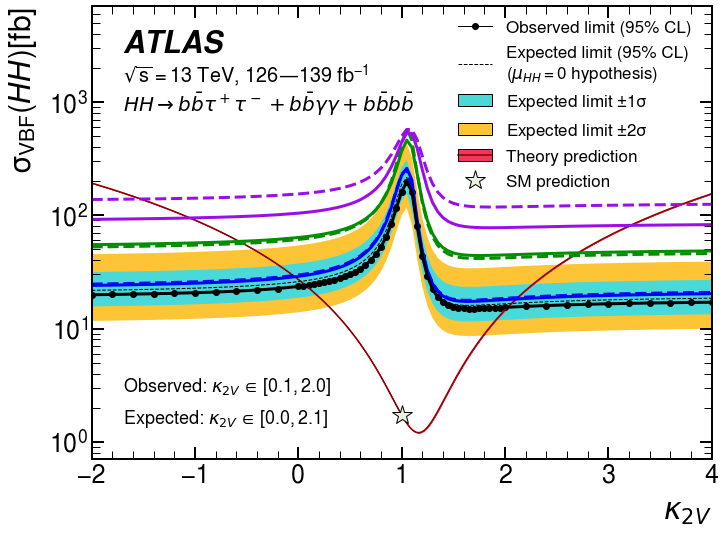

In [91]:
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'bbyy', mH, production, poi)
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'bbtautau', mH, production, poi)
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'bbbb', mH, production, poi)
# theory_line = plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi)

for status in statuses:
    plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi, xmin=-2, xmax=4, status=status)
#     plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi, xmin=-0.5, xmax=2.5, add_individual=False, status=status)
    # plot_xsection_scan_k2v(k2v_param_limit_df, 'combined', mH, production, poi, xmin=-2, xmax=4, disable_error=True, status=status)


## 3. 2D cross section scan

In [205]:
from quickstats.plots import Likelihood2DPlot, UpperLimit3DPlot

def plot_2D_xs(channel, pois, mH, save=False):
    styles = {
        'legend':{
            'loc': (0.05, 0.05),
            'fontsize': 18,
            },
        'xtick':{
            'format': 'numeric',
            'steps': [1, 10],
            'nbins': 20
            },
        'ytick':{
            'steps': [1,10],
            'nbins': 10
        }
    }
    analysis_label_options_default = {
        'status': 'int',
        'energy': '13 TeV',
        'lumi': '126—139 fb$^{-1}$',
        'fontsize': 30,
        'loc': (0.05, 0.95),
    }
    analysis_label_options = {
        'loc': (0.05, 0.95),
        'energy': '13 TeV',
        'lumi': r'126—139 fb$^{-1}$',
        'fontsize': 30,
        'extra_text':channel_text[channel] # + '//Parameterised workspace'    
    }
    
    config = {
        'sm_values': (1,1),
        'sm_pos': 0.78,
        'sm_line_styles':{
            'color': 'gray',
            'linestyle': 'dashdot'
        }
    }
    
    in_path = f'{outdir_xsection}/xsection_scan/{channel}/{pois}/limits.json'
    out_path = f'{outdir_xsection}/figures/xsection_scan/{pois}_limit_parameterised_ws_{channel}.pdf'
    
    data = json.load(open(in_path))
    df = pd.DataFrame(data)
    if df.isnull().values.any():
        print('WARN', df)

    theory_combination_function = get_theory_combination_function(mH)
    couplings = [None, None, None]
    if pois == 'klambdak2v':
        kv = 1
        x, y = 'klambda', 'k2V'
        xlabel, ylabel = '$\mathit{\kappa_\lambda}$', '$\mathit{\kappa_{2V}}$'
        xlim = [-10, 15]
        ylim = [-5, 5]
    elif pois == 'k2vkv':
        klambda = 1
        x, y = 'k2V', 'kV'
        xlabel, ylabel = '$\kappa_{2V}$', '$\kappa_{V}$'
        xlim = [-3, 6]
        ylim = [-5, 5]
    else:
        assert(0), f'{pois} is not supported'
    num_grid_points = 1000
    X_range = df[x].min(), df[x].max()
    Y_range = df[y].min(), df[y].max()
    X, Y = UpperLimit3DPlot.get_grid(X_range, Y_range, num_grid_points)
    if pois == 'klambdak2v':
        couplings1 = [X, Y, kv]
        couplings2 = [df[x], df[y], np.ones(df.shape[0])]
    elif pois == 'k2vkv':
        couplings1 = [klambda, X, Y]
        couplings2 = [np.ones(df.shape[0]), df[x], df[y]]
    theory_grid = theory_combination_function(couplings1)
    theory_xsec = theory_combination_function(couplings2)
    
    plotter = UpperLimit3DPlot(df, num_grid_points=num_grid_points, styles=styles, analysis_label_options=analysis_label_options)
    plotter.config = combine_dict(plotter.config, config)
    plotter.add_highlight(1, 1, label="SM prediction")
    plotter.draw(x=x, y=y, xlabel=xlabel, ylabel=ylabel, scale_factor=theory_xsec, theory_grid=theory_grid, draw_observed=True, ylim=ylim, xlim=xlim, draw_sm_line=True)
    if save:
        plt.savefig(out_path, bbox_inches="tight")
        print('Save to', out_path)
    return df
        


In [81]:
# save = True
# plot_2D_xs('bbyy', 'klambdak2v', mH=mH, save=save)
# plot_2D_xs('bbtautau', 'klambdak2v', mH=mH, save=save)
# plot_2D_xs('bbbb', 'klambdak2v', mH=mH, save=save)
# plot_2D_xs('combined', 'klambdak2v', mH=mH, save=save)

In [82]:
# save = True
# plot_2D_xs('bbyy', 'k2vkv', mH=mH, save=save)
# plot_2D_xs('bbtautau', 'k2vkv', mH=mH, save=save)
# plot_2D_xs('bbbb', 'k2vkv', mH=mH, save=save)
# df = plot_2D_xs('combined', 'k2vkv', mH=mH, save=save)

## 3. Likelihood Scan

In [23]:
def get_likelihood_data(obs, study, combine_only):
    data = {}
    filename = study.replace('_profile', '').replace('_2D', '') + '.json'
    channels = [] if combine_only else ['bbbb', 'bbtautau', 'bbyy']
    for channel in channels+['combined']:
        limit_path = os.path.join(outdir_likelihood, 'likelihood', obs, channel, study, filename)
        try:
            data[channel] = json.load(open(limit_path))
        except:
            print(limit_path)
            raise
    return data
    
def data_loading_lh(obs, study, cut=1000, combine_only=False):
    likelihood_df, uncond_df = {}, {}
    data = get_likelihood_data(obs, study, combine_only)
    for channel in data:
        df = pd.DataFrame(data[channel]).dropna(axis=1, how='all')
        if 'klambda' not in df:
            df.rename(columns = {'mu':'klambda'}, inplace = True)
            
        df_uncond = df.drop(index=df.index[1:], axis=0, inplace=False)
        df_scan = df.drop(index=df.index[0], axis=0, inplace=False)
        df_scan = df_scan.drop(df_scan[df_scan['qmu']>cut].index)
        likelihood_df[channel] = df_scan
        uncond_df[channel] = df_uncond
    return likelihood_df, uncond_df

In [24]:
from quickstats.plots import Likelihood1DPlot
from quickstats.plots.color_schemes import QUICKSTATS_PALETTES
color_pallete = QUICKSTATS_PALETTES['default']
from scipy.interpolate import interp1d
def get_interval(df, level):
    xvalues = df['klambda'].to_numpy()
    yvalues = df['qmu'].to_numpy()
    func_theory = interp1d(xvalues, yvalues)
    x_new = np.arange(min(xvalues), max(xvalues), 0.0001)
    y_new = func_theory(x_new)
    
    asign = np.sign(y_new-level)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    intersections = x_new[signchange==1]
    return intersections

In [25]:
studies = ['klambda', 'klambda_kt_profile', 'kV', 'kF', 'kt', 'kV_k2V_2D', 'klambda_kt_2D', 'k2V']
studies = ['klambda', 'k2V'] #['k2V_kV_profile'] #
obs = ['expected', 'observed']

likelihood_df, uncond_df = {}, {}
for o in obs:
    for study in studies:
        try:
            likelihood_df[f'{study}_{o}'], uncond_df[f'{study}_{o}'] = data_loading_lh(o, study, cut=6.5 if study=='klambda' or study=='k2V' else 1000, combine_only=(True if study=='k2V_kV_profile' else False))
        except:
            print(o, study)
            raise

likelihood_df.keys()

dict_keys(['klambda_expected', 'k2V_expected', 'klambda_observed', 'k2V_observed'])

#### Convert to google sheet

In [26]:
# google_likelihood_df, google_uncond_df = {}, {}
# for o in ['postfit2']:
#     for study in ['1D_kt_nominal', '1D_kt_profiled']:
#         google_likelihood_df[f'google_{study}_{o}'], google_uncond_df[f'google_{study}_{o}'] = data_loading_lh(o, study, drop_bestfit=True)


# for k in google_likelihood_df:
#     for channel in google_likelihood_df[k]:
#         df_no_bestfit = google_likelihood_df[k][channel]
# #         print(df_no_bestfit)
#         val_str = ",".join([f"{v}" for v in df_no_bestfit['qmu'].values])
#         print(k, channel)
#         print(val_str)
#         print()

In [27]:
# for k in google_uncond_df:
#     for channel in google_uncond_df[k]:
#         print(k, channel)
#         print(google_uncond_df[k][channel]['muhat']['klambda'])

In [28]:
# styles_map = {
#     'bbbb': {"color": color_pallete[4], "marker": "^"},
#     'bbyy': {"color": color_pallete[1], "marker": "s"},
#     'bbtautau': {"color": color_pallete[2], "marker": "v"},
#     'combined': {"color": color_pallete[0], "marker": "o"},
# }

styles_map = {
    'bbbb': {"color": 'b', "marker": ","},
    'bbyy': {"color": "#9A0EEA", "marker": ","},
    'bbtautau': {"color": "#008F00", "marker": ","},
    'combined': {"color": 'k', "marker": ","},
}

styles = {
    'HHH': {
        'legend': {
            'loc': (0.7, 0.66)
        },
        'plot': {
            'linewidth': 3,
        },
        'axis': {
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'klambda': {
        'legend': {
            'loc': 'upper right'
        },
        'plot': {
            'linewidth': 3,
        },
        'axis': {
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'k2V': {
        'legend': {
            'loc': 'upper right'
        },
        'plot': {
            'linewidth': 3,
        },
        'axis': {
            'labelsize': 25,
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    '1D_kt_profiled': {
        'legend': {
            'loc': (0.17, 0.40)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    '2D_kl_kt': {
        'legend': {
            'loc': (0.17, 0.42)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'klambda_kt_2D': {
        'legend': {
            'loc': (0.17, 0.42)
        },
    },
    'kV_k2V_2D': {
        'legend': {
            'loc': (0.17, 0.42)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
    'klambda_kt_2D': {
        'legend': {
            'loc': (0.17, 0.40)
        },
        'xlabel': {
            'fontsize': 30,
        },
        'ylabel': {
            'fontsize': 30,
        },
    },
}
anno_op = {
    'klambda': {
        'x': 0.3,
        'y': 0.64,
        'dy': 0.065,
        'font_size': 19,
    },
    'k2V': {
        'x': 0.35,
        'y': 0.64,
        'dy': 0.065,
        'font_size': 19,
    },
    'k2V_kV_profile': {
        'x': 0.35,
        'y': 0.64,
        'dy': 0.065,
        'font_size': 19,
    },
    '1D_kt_nominal': {
        'x': 0.30,
        'y': 0.42,
        'dy': 0.065,
        'font_size': 19,
    },
    '1D_kt_profiled': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    '2D_kl_kt': {
        'x': 0.30,
        'y': 0.42,
        'dy': 0.065,
        'font_size': 19,
    },
    'klambda_kt_2D': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
    'kV_k2V_2D': {
        'x': 0.48,
        'y': 0.62,
        'dy': 0.065,
        'font_size': 19,
    },
}

print(anno_op)
for study in studies:
    if study not in styles:
        print(study, studies)
        styles[study] = {
                'legend': {
                    'loc': (0.19, 0.42)
                },
            }
    if study not in anno_op:
        anno_op[study] = {
                'x': 0.3,
                'y': 0.7,
                'dy': 0.065,
                'font_size': 19,
            }


def analysis_label_options_new(study, obs, channel='combined', status='int'):
    if obs == 'obs':
        text = 'Observed'
    elif obs == 'prefit2':
        text = 'Prefit Asimov'
    elif obs == 'prefit':
        text = 'Postfit Asimov'
    elif obs == 'expected':
        text = 'Expected SM'
    elif obs == 'observed':
        text = 'Observed'
    elif obs == 'combined':
        text = ''
    else:
        text = 'Unknown'

    label_options = {
        'klambda': {
            'status': status,
            'loc': (0.05, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text}", # + r", $\kappa_{t} = 1$",
        },
        'k2V': {
            'status': status,
            'loc': (0.05, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text}", # + r", $\kappa_{t} = 1$",
        },
        'k2V_kV_profile': {
            'loc': (0.05, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text}" + r", $\kappa_{V}$ profiled",
        },
        'klambda_kt_profile': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data" + r", $\kappa_{t}$ profiled",
        },
        'default': {
            'loc': (0.19, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data" + r", $\kappa_{t} = 1$",
        },
        'kV_k2V_2D': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data",
        },
        'klambda_kt_2D': {
            'loc': (0.17, 0.96),
            'fontsize': 25, # ATLAS
            'energy': '13 TeV',
            'lumi': r'126—139 fb$^{-1}$',
            'extra_text': channel_text[channel] + f"//{text} data",
        },
    }
    if study in label_options:
        return label_options[study]
    else:
        return label_options['default']


{'klambda': {'x': 0.3, 'y': 0.64, 'dy': 0.065, 'font_size': 19}, 'k2V': {'x': 0.35, 'y': 0.64, 'dy': 0.065, 'font_size': 19}, 'k2V_kV_profile': {'x': 0.35, 'y': 0.64, 'dy': 0.065, 'font_size': 19}, '1D_kt_nominal': {'x': 0.3, 'y': 0.42, 'dy': 0.065, 'font_size': 19}, '1D_kt_profiled': {'x': 0.48, 'y': 0.62, 'dy': 0.065, 'font_size': 19}, '2D_kl_kt': {'x': 0.3, 'y': 0.42, 'dy': 0.065, 'font_size': 19}, 'klambda_kt_2D': {'x': 0.48, 'y': 0.62, 'dy': 0.065, 'font_size': 19}, 'kV_k2V_2D': {'x': 0.48, 'y': 0.62, 'dy': 0.065, 'font_size': 19}}


### 3.1 1D klambda

In [29]:
from quickstats.maths.numerics import is_integer, pretty_value
import pandas

def plot_1D(likelihood_df, study, obs, xmin = -15, xmax = 20, ymin=0, ymax = 12, xlabel=r"$\mathit{\kappa_{\lambda}}$", xattrib='klambda', yattrib='qmu', status='int'):
    dic = {}
    options = {}
    config = {
        'sigma_values': (1, 3.84),
        'sigma_levels': ('1sigma', '0.95'),
        'sigma_names': ('68%', '95%'),
        'sigma_pos': 0.89,
     }
    name = 'likelihood_scan'
    if yattrib == 'kt':
        options['ylabel'] = r"Best fit $\mathit{\kappa_{t}}$"
        options['draw_sigma_line'] = False
        name = yattrib
    if yattrib == 'qmu' and ymax < 4:
        options['draw_sigma_line'] = False
        name += '_zoom'
    
    df_index = f'{study}_{obs}'
    plotter = Likelihood1DPlot(likelihood_df[df_index], label_map=channel_label_map if obs != 'combined' else channel_label_map_alter, styles_map=styles_map if obs != 'combined' else styles_map_alter,
                            styles=styles[study], analysis_label_options=analysis_label_options_new(study, obs, status=status),
                              config = config)
    ax = plotter.draw(xlabel=xlabel, ylabel="$-2\ ln\ \Lambda$", ymin=ymin, ymax=ymax, xmin=xmin, xmax=xmax, xattrib=xattrib, yattrib=yattrib, **options)
    if 'combined' in likelihood_df[df_index] and yattrib=='qmu':
        dic['combined'] = {}
        intersections_1 = get_intersections(likelihood_df[df_index]['combined']['klambda'].values, likelihood_df[df_index]['combined']['qmu'].values, level=config['sigma_values'][0], delta=0.0001)[0]
        intersections_2 = get_intersections(likelihood_df[df_index]['combined']['klambda'].values, likelihood_df[df_index]['combined']['qmu'].values, level=config['sigma_values'][1], delta=0.0001)[0]
        dic['combined'][f"{config['sigma_values'][0]} low"] = intersections_1[0]
        dic['combined'][f"{config['sigma_values'][0]} high"] = intersections_1[1]
        dic['combined'][f"{config['sigma_values'][1]} low"] = intersections_2[0]
        dic['combined'][f"{config['sigma_values'][1]} high"] = intersections_2[1]

        ax.annotate(r'Combined:', 
                    (anno_op[study]['x'], anno_op[study]['y']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$68\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_1[0], intersections_1[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])
        ax.annotate(r'$95\%$: '+xlabel+r'$ \in [%.1f, %.1f]$' %(intersections_2[0], intersections_2[1]), 
                    (anno_op[study]['x'], anno_op[study]['y'] - 2 * anno_op[study]['dy']), xycoords = 'axes fraction', fontsize = anno_op[study]['font_size'])


        for c in ['bbyy', 'bbtautau', 'bbbb']:
            if c not in dic:
                dic[c] = {}
                
            intersections_1 = get_intersections(likelihood_df[df_index][c]['klambda'].values, likelihood_df[df_index][c]['qmu'].values, level=config['sigma_values'][0], delta=0.0001)[0]
            intersections_2 = get_intersections(likelihood_df[df_index][c]['klambda'].values, likelihood_df[df_index][c]['qmu'].values, level=config['sigma_values'][1], delta=0.0001)[0]
            dic[c][f"{config['sigma_values'][0]} low"] = intersections_1[0]
            dic[c][f"{config['sigma_values'][0]} high"] = intersections_1[1]
            dic[c][f"{config['sigma_values'][1]} low"] = intersections_2[0]
            dic[c][f"{config['sigma_values'][1]} high"] = intersections_2[1]
        
    df = pandas.DataFrame.from_dict(dic)
    savefolder = outdir_likelihood + f'/figures/likelihood_scan/{status}/'
    os.makedirs(savefolder, exist_ok=True)
    filename = savefolder+f"/{name}_{df_index}_{status}.pdf"
#     plt.savefig(filename, bbox_inches="tight")
    df.to_csv(filename.replace('.pdf', '_interval.csv'))
    for channel in likelihood_df[df_index]:
        likelihood_df[df_index][channel].to_csv(filename.replace('.pdf', f'_{df_index}_{channel}.csv'), index=False)
    print('Save', filename)
    return df

In [30]:
def kappa_name_1D(study):
    name_map = {
        'klambda': r"$\mathit{\kappa_{\lambda}}$",
        'kV': r"$\mathit{\kappa_{V}}$",
        'kF': r"$\mathit{\kappa_{F}}$",
        'kt': r"$\mathit{\kappa_{t}}$",
        'k2V': r"$\mathit{\kappa_{2V}}$",
        'klambda_kt_profile': r"$\mathit{\kappa_{\lambda}}$",
    }
    xrange = {
        'klambda': (-6, 15),
        'k2V': (-2, 4),
    }
    yrange = {
        'klambda':  (0, 10),
        'k2V': (0, 10),
    }
    return name_map[study], study, xrange[study], yrange[study]

Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation//figures/likelihood_scan/final//likelihood_scan_klambda_expected_final.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation//figures/likelihood_scan/final//likelihood_scan_klambda_observed_final.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation//figures/likelihood_scan/final//likelihood_scan_k2V_expected_final.pdf
Save /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation//figures/likelihood_scan/final//likelihood_scan_k2V_observed_final.pdf
klambda expected


,1 low,1 high,3.84 low,3.84 high
combined,-0.7888,6.2786,-2.1176,7.8416
bbyy,-1.4247,6.3021,-3.1534,8.0730
bbtautau,-1.3685,8.4076,-3.0721,10.1707
bbbb,-2.8509,9.0833,-5.1828,11.5672


\begin{tabular}{lrrrr}
\toprule
{} &   1 low &  1 high &  3.84 low &  3.84 high \\
\midrule
combined & -0.7888 &  6.2786 &   -2.1176 &     7.8416 \\
bbyy     & -1.4247 &  6.3021 &   -3.1534 &     8.0730 \\
bbtautau & -1.3685 &  8.4076 &   -3.0721 &    10.1707 \\
bbbb     & -2.8509 &  9.0833 &   -5.1828 &    11.5672 \\
\bottomrule
\end{tabular}

klambda observed


,1 low,1 high,3.84 low,3.84 high
combined,1.0434,5.0341,-0.5786,6.5680
bbyy,0.5621,4.7546,-1.4326,6.4630
bbtautau,-0.9483,7.4571,-2.6581,9.4692
bbbb,0.9358,9.1652,-3.2667,11.3781


\begin{tabular}{lrrrr}
\toprule
{} &   1 low &  1 high &  3.84 low &  3.84 high \\
\midrule
combined &  1.0434 &  5.0341 &   -0.5786 &     6.5680 \\
bbyy     &  0.5621 &  4.7546 &   -1.4326 &     6.4630 \\
bbtautau & -0.9483 &  7.4571 &   -2.6581 &     9.4692 \\
bbbb     &  0.9358 &  9.1652 &   -3.2667 &    11.3781 \\
\bottomrule
\end{tabular}

k2V expected


,1 low,1 high,3.84 low,3.84 high
combined,0.3367,1.7454,0.0198,2.0664
bbyy,-0.6764,2.8560,-1.5508,3.7320
bbtautau,-0.0442,2.1679,-0.5362,2.6620
bbbb,0.2972,1.7728,-0.0493,2.1239


\begin{tabular}{lrrrr}
\toprule
{} &   1 low &  1 high &  3.84 low &  3.84 high \\
\midrule
combined &  0.3367 &  1.7454 &    0.0198 &     2.0664 \\
bbyy     & -0.6764 &  2.8560 &   -1.5508 &     3.7320 \\
bbtautau & -0.0442 &  2.1679 &   -0.5362 &     2.6620 \\
bbbb     &  0.2972 &  1.7728 &   -0.0493 &     2.1239 \\
\bottomrule
\end{tabular}

k2V observed


,1 low,1 high,3.84 low,3.84 high
combined,0.4397,1.6688,0.0926,2.0144
bbyy,0.1008,2.0548,-0.8243,2.9838
bbtautau,-0.1118,2.2627,-0.5852,2.7260
bbbb,0.3480,1.7166,-0.0261,2.1025


\begin{tabular}{lrrrr}
\toprule
{} &   1 low &  1 high &  3.84 low &  3.84 high \\
\midrule
combined &  0.4397 &  1.6688 &    0.0926 &     2.0144 \\
bbyy     &  0.1008 &  2.0548 &   -0.8243 &     2.9838 \\
bbtautau & -0.1118 &  2.2627 &   -0.5852 &     2.7260 \\
bbbb     &  0.3480 &  1.7166 &   -0.0261 &     2.1025 \\
\bottomrule
\end{tabular}



<Figure size 432x288 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

<Figure size 799.992x599.976 with 0 Axes>

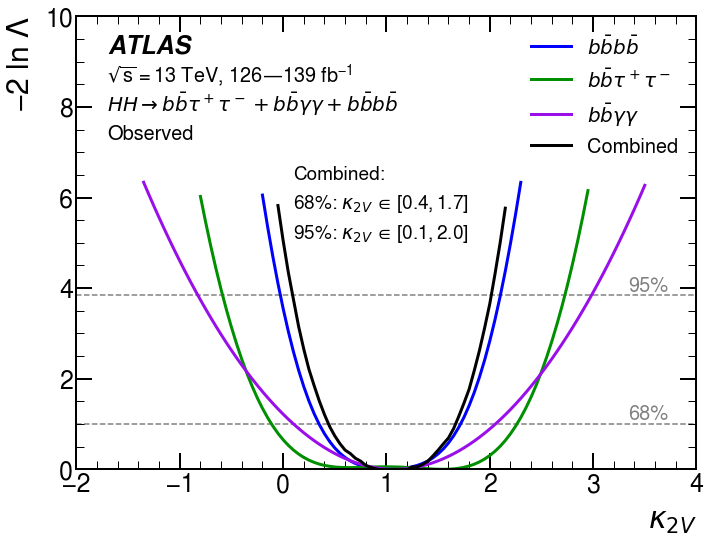

In [31]:
from IPython.display import display, HTML

# 1D
df_all = {}

for study in studies:
    if '_' in study and 'profile' not in study: continue
    df_all[study] = {}
    for o in obs:
        df_all[study][o] = []
        xlabel, xattrib, xrange, yrange = kappa_name_1D(study)
        if 'profile' in study:
            xattrib = xattrib.split('_')[0]
        for status in statuses:
            df = plot_1D(likelihood_df, study, o, xlabel=xlabel, xattrib=xattrib, xmin = xrange[0], xmax = xrange[1], ymin=yrange[0], ymax = yrange[1], status=status)
        df_all[study][o].append(df)

        
for study in df_all:
    for o in df_all[study]:
        tab = pd.concat(df_all[study][o]).T
        print(study, o)
        display(tab)
        print(tab.to_latex())



## read bestfit

In [86]:
import pandas as pd

studies = ['klambda', 'k2V'] #['k2V_kV_profile'] #
channels = ['bbtautau', 'bbyy', 'bbbb', 'combined']

for poi_str in studies:
    df_all = []
    for job in obs:
        for channel in channels:
            outpath = os.path.join(outdir_likelihood, "likelihood", job, channel, poi_str, 'cache', f'{poi_str}_uncond.json')
            with open(outpath) as fp:
                dic = json.load(fp)['uncond_fit']
            df = pd.DataFrame.from_dict(dic).drop(['status', 'time', 'nll'], axis=1)
            df.insert(0, 'channel', channel)
            df.insert(1, 'dataset', job)
            df_all.append(df)
    df_all = pd.concat(df_all)
    savefolder = f'{outdir_likelihood}/figures/bestfit/'
    os.makedirs(savefolder, exist_ok=True)
    df_all.to_csv(f'{savefolder}/{poi_str}.csv')
    print('save to', savefolder)
    display(df_all)

save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation//figures/bestfit/


,channel,dataset,muhat,muhat_errlo,muhat_errhi
klambda,bbtautau,expected,1.000007,-3.269761,3.269761
klambda,bbyy,expected,1.000074,-3.516757,3.516757
klambda,bbbb,expected,1.000003,-6.799667,6.799667
klambda,combined,expected,1.000004,-2.321661,2.321661
klambda,bbtautau,observed,1.509777,-3.536213,3.536213
klambda,bbyy,observed,2.753165,-2.131532,2.131532
klambda,bbbb,observed,6.180242,-3.749614,3.749614
klambda,combined,observed,3.086072,-2.106580,2.106580


save to /afs/cern.ch/work/z/zhangr/HHcomb/hh_combination_fw/hh_combination_fw/tutorials/HHH2022/outputs_HHH2022_20220701_with_BR_decorrelation//figures/bestfit/


,channel,dataset,muhat,muhat_errlo,muhat_errhi
k2V,bbtautau,expected,1.000056,-6.085540,6.085540
k2V,bbyy,expected,1.000124,-12.893607,12.893607
k2V,bbbb,expected,1.000000,-3.946223,3.946223
k2V,combined,expected,1.000024,-2.871444,2.871444
k2V,bbtautau,observed,1.547212,-1.149107,1.149107
k2V,bbyy,observed,1.078524,-0.977468,0.977468
k2V,bbbb,observed,0.992660,-1.022675,1.022675
k2V,combined,observed,1.069339,-0.637454,0.637454
